## Step 1. 데이터 전처리

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['seaborn'])

import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

In [39]:
df_raw = pd.read_csv('./data/bitcoin.csv', thousands=',')
df_raw.tail()

,날짜,종가,오픈,고가,저가,거래량,변동 %
1853,2016년 12월 12일,778.5,767.9,781.3,767.9,28.76K,1.38%
1854,2016년 12월 11일,767.9,774.0,774.2,763.0,17.14K,-0.79%
1855,2016년 12월 10일,774.0,770.5,777.0,769.2,18.02K,0.46%
1856,2016년 12월 09일,770.5,768.5,773.5,765.0,24.18K,0.26%
1857,2016년 12월 08일,768.5,765.6,773.4,761.2,28.78K,0.38%


In [40]:
df = df_raw[['종가']].astype('float64')
df.index = pd.to_datetime(df_raw['날짜'], format="%Y년 %m월 %d일")
df.columns = ['close']
df.index.name = 'date'
df.sort_index(inplace=True)
df

,close
date,
2016-12-08,768.5
2016-12-09,770.5
2016-12-10,774.0
2016-12-11,767.9
2016-12-12,778.5
...,...
2022-01-04,45837.3
2022-01-05,43425.9
2022-01-06,43097.5


In [44]:
df.index

DatetimeIndex(['2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11',
               '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15',
               '2016-12-16', '2016-12-17',
               ...
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-08'],
              dtype='datetime64[ns]', name='date', length=1858, freq='D')

In [45]:
df.index.freq='D'
df.index

DatetimeIndex(['2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11',
               '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15',
               '2016-12-16', '2016-12-17',
               ...
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-08'],
              dtype='datetime64[ns]', name='date', length=1858, freq='D')

## Step 2. 이동평균과 지수평활

### 2-1. 단순 종가

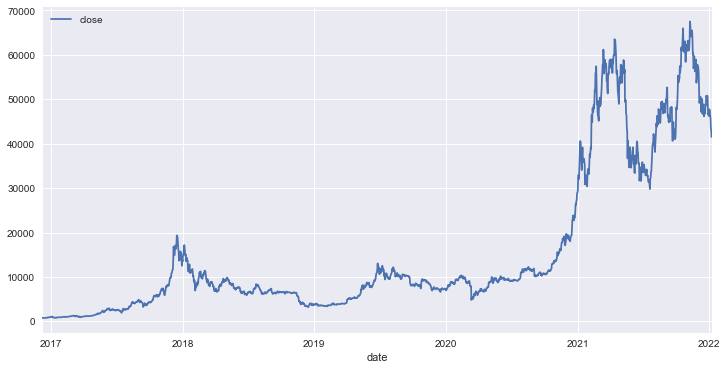

In [46]:
df.plot(figsize=(12,6));

### 2-2. 120일, 300일 이동평균

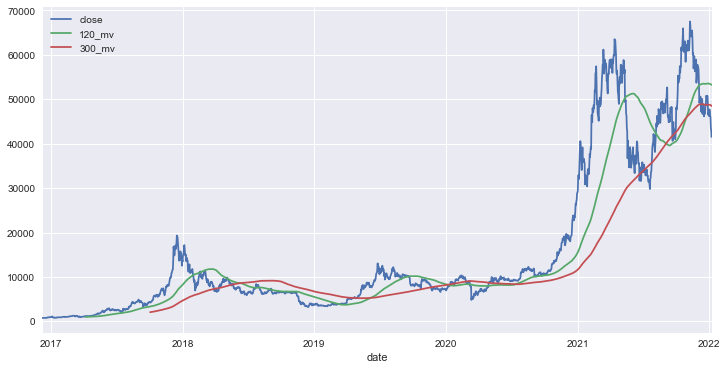

In [47]:
df['120_mv'] = df['close'].rolling(window=120).mean()
df['300_mv'] = df['close'].rolling(window=300).mean()
df.plot(figsize=(12,6));

### 2-3. 단순 지수 평활

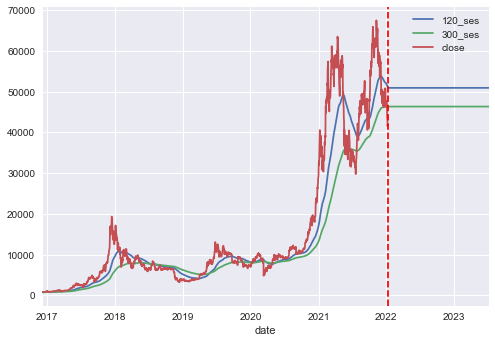

In [58]:
span = 120 # the period of moving average
ses = SimpleExpSmoothing(df['close'])
ses = ses.fit(smoothing_level=2/(span+1), optimized=False)
ses.predict(start=0, end=2400).plot(label='120_ses')
ses = ses.fittedvalues.shift(-1)
df['120_ses'] = ses

span = 300
ses = SimpleExpSmoothing(df['close'])
ses = ses.fit(smoothing_level=2/(span+1), optimized=False)
ses.predict(start=0, end=2400).plot(label='300_ses')
ses = ses.fittedvalues.shift(-1)
df['300_ses'] = ses

df['close'].plot(label='close')

plt.legend()
plt.axvline(df.index[-1], c='r', linestyle='--')

plt.show()

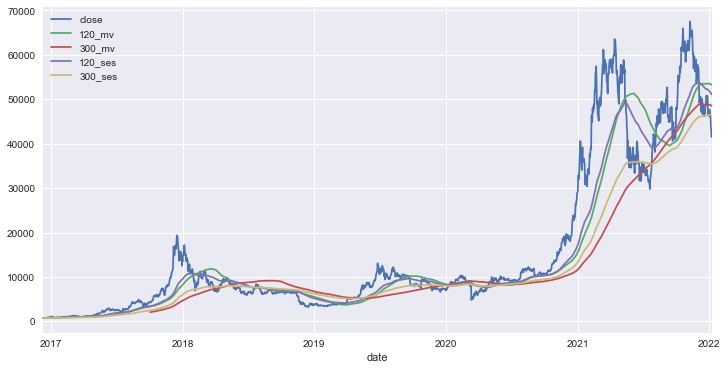

In [49]:
df.plot(figsize=(12,6));

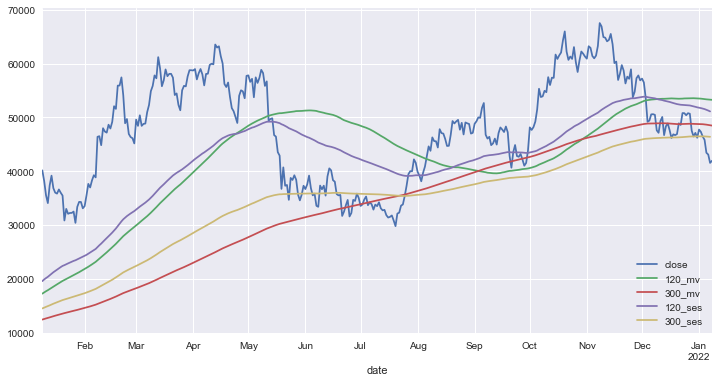

In [50]:
df.iloc[-365:].plot(figsize=(12,6));

## Step 3. 추세와 계절성을 추가한 2차, 3차 지수 평활

### 3-1. 2차 지수평활

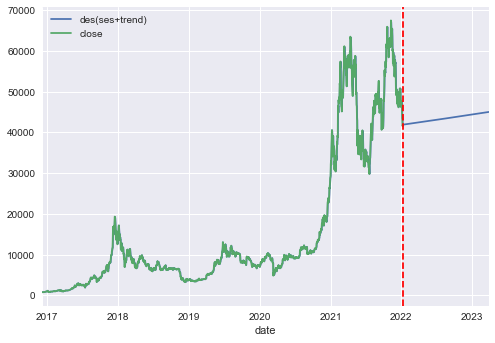

In [59]:
des = ExponentialSmoothing(df['close'], trend='mul')
des = des.fit()
des.predict(start=0, end=2300).plot(label='des(ses+trend)')
des = des.fittedvalues
df['des'] = des

df['close'].plot(label='close')

plt.axvline(df.index[-1], c='r', linestyle='--')

plt.legend()
plt.show()

### 3-2. 3차 지수평활

In [79]:
tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=90)
tes = tes.fit()
tes.predict(start=0,end=1900)

2016-12-08      772.173691
2016-12-09      774.399279
2016-12-10      777.755476
2016-12-11      771.433485
2016-12-12      781.892956
                  ...     
2022-02-16    20116.054700
2022-02-17    19553.341477
2022-02-18    19390.183023
2022-02-19    19051.954237
2022-02-20    18784.826073
Freq: D, Length: 1901, dtype: float64

/Users/swsong/opt/anaconda3/envs/dataScience/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


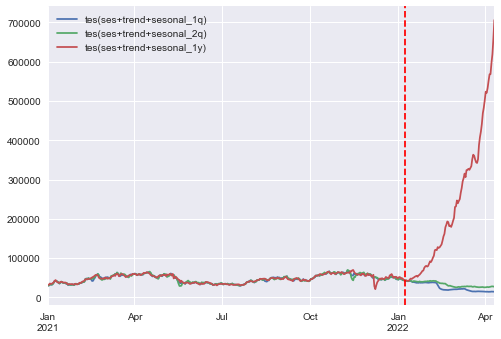

In [87]:
tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=90)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_1q)')
tes = tes.fittedvalues
df['1q_tes'] = tes

tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=180)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_2q)')
tes = tes.fittedvalues
df['2q_tes'] = tes

tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=365)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_1y)')
tes = tes.fittedvalues
df['1y_tes'] = tes

plt.axvline(df.index[-1], c='r', linestyle='--')

plt.legend()
plt.show()

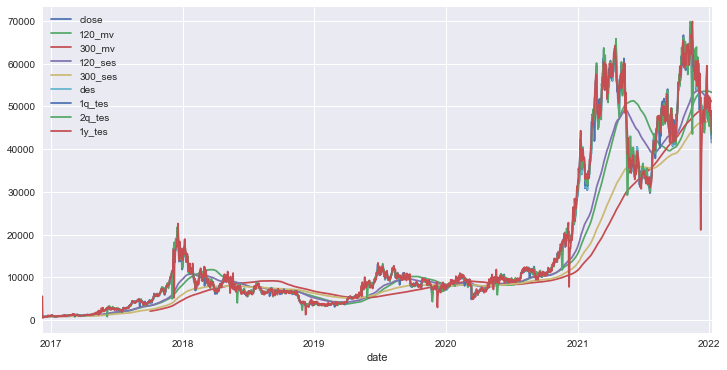

In [71]:
df.plot(figsize=(12,6));

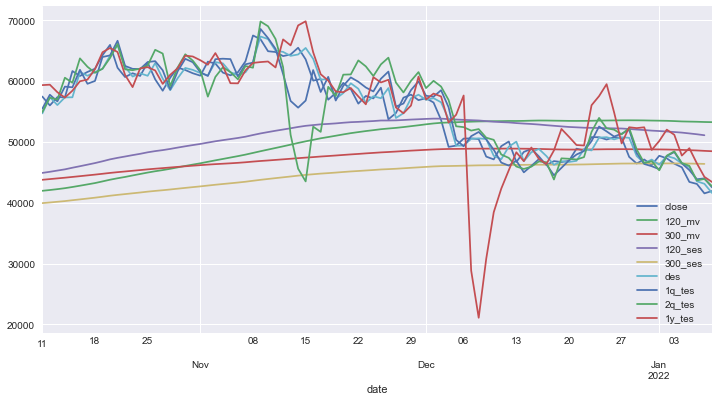

In [72]:
df.iloc[-90:].plot(figsize=(12,6));